In [1]:
import os
import tensorflow as tf
from transformers import TFGPT2Model

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import gluonnlp as nlp
from gluonnlp.data import SentencepieceTokenizer

import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import re

아레 실행 커멘드는 gpt_ckpt 폴더가 있지 않은 경우에만 실행해주세요.

In [2]:
import wget
import zipfile

# wget.download('https://github.com/NLP-kr/tensorflow-ml-nlp-tf2/releases/download/v1.0/gpt_ckpt.zip')

with zipfile.ZipFile('gpt_ckpt.zip') as z:
    z.extractall()

In [3]:
# 시각화

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)
np.random.seed(SEED_NUM)

## 데이터 준비하기

In [26]:
TOKENIZER_PATH = './gpt_ckpt/gpt2_kor_tokenizer.spiece'

tokenizer = SentencepieceTokenizer(TOKENIZER_PATH)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(TOKENIZER_PATH,
                                               mask_token=None,
                                               sep_token='<unused0>',
                                               cls_token=None,
                                               unknown_token='<unk>',
                                               padding_token='<pad>',
                                               bos_token='<s>',
                                               eos_token='</s>')
# vocab = vocab()
# vocab()

In [27]:
print(len(vocab))

50000


In [7]:
BATCH_SIZE = 32
NUM_EPOCHS = 3
SENT_MAX_LEN = 31

DATA_IN_PATH = './data_in/KOR'
DATA_OUT_PATH = "./data_out/KOR"

In [8]:
# Load Train dataset

TRAIN_SNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'snli_1.0_train.kor.tsv')
TRAIN_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'multinli.train.ko.tsv')
DEV_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.dev.ko.tsv')

train_data_snli = pd.read_csv(TRAIN_SNLI_DF, header=0, delimiter='\t', quoting=3)
train_data_xnli = pd.read_csv(TRAIN_XNLI_DF, header=0, delimiter='\t', quoting=3)
dev_data_xnli = pd.read_csv(DEV_XNLI_DF, header=0, delimiter='\t', quoting=3)

train_data_snli_xnli = train_data_snli.append(train_data_xnli)
train_data_snli_xnli = train_data_snli_xnli.dropna()
train_data_snli_xnli = train_data_snli_xnli.reset_index()

dev_data_xnli = dev_data_xnli.dropna()

print("Total # dataset: train - {}, dev - {}".format(len(train_data_snli_xnli), len(dev_data_xnli)))

Total # dataset: train - 942808, dev - 2490


In [9]:
print(vocab.bos_token)
print(vocab.sep_token)
print(vocab.eos_token)

<s>
<unused0>
</s>


In [10]:
# 토크나이저를 제외하고는 5장에서 처리한 방식과 유사하게 접근
def clean_text(sent):
    sent_clean = re.sub("[^가-힣ㄱ-ㅎㅏ-ㅣ\\s]", " ", sent)
    return sent_clean

train_data_sents = []

for train_sent_1, train_sent_2 in train_data_snli_xnli[['sentence1', 'sentence2']].values:
    train_tokenized_sent_1 = vocab[tokenizer(clean_text(train_sent_1))]
    train_tokenized_sent_2 = vocab[tokenizer(clean_text(train_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([train_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([train_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    train_data_sents.append(tokens)    

train_data_sents = np.array(train_data_sents, dtype=np.int64)

In [11]:
print(train_data_sents[0])

[    0 47437 47637 47444 47437 47874 47437 47457 47788 47438 47437 47447
 47475 47612 47437 47506 47552 47449 47437 47498 47446 47437 48131 47487
 47531 47738 47439     3     3     3     3     3     6 47437 47450 47437
 47457 47788 47438 47437 47499 47862 47444 47437 47498 47466 47437 47637
 47444 47437 47931 47713 47460 47758 47447 47437 47477 47439     3     3
     3     3     3     3     1]


In [12]:
dev_data_sents = []

for dev_sent_1, dev_sent_2 in dev_data_xnli[['sentence1', 'sentence2']].values:
    dev_tokenized_sent_1 = vocab[tokenizer(clean_text(dev_sent_1))]
    dev_tokenized_sent_2 = vocab[tokenizer(clean_text(dev_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([dev_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([dev_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    dev_data_sents.append(tokens)    

dev_data_sents = np.array(dev_data_sents, dtype=np.int64)

In [13]:
# Label을 Netural, Contradiction, Entailment 에서 숫자 형으로 변경한다.
label_dict = {"entailment": 0, "contradiction": 1, "neutral": 2}

def convert_int(label):
    num_label = label_dict[label]    
    return num_label

train_data_snli_xnli["gold_label_int"] = train_data_snli_xnli["gold_label"].apply(convert_int)
train_data_labels = np.array(train_data_snli_xnli['gold_label_int'], dtype=int)

dev_data_xnli["gold_label_int"] = dev_data_xnli["gold_label"].apply(convert_int)
dev_data_labels = np.array(dev_data_xnli['gold_label_int'], dtype=int)

print("# train labels: {}, #dev labels: {}".format(len(train_data_labels), len(dev_data_labels)))

# train labels: 942808, #dev labels: 2490


## 모델 학습

In [14]:
class TFGPT2Classifier(tf.keras.Model):
    def __init__(self, dir_path, num_class):
        super(TFGPT2Classifier, self).__init__()
        
        self.gpt2 = TFGPT2Model.from_pretrained(dir_path)
        self.num_class = num_class
        
        self.dropout = tf.keras.layers.Dropout(self.gpt2.config.summary_first_dropout)
        self.classifier = tf.keras.layers.Dense(self.num_class, 
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=self.gpt2.config.initializer_range), 
                                                name="classifier")
        
    def call(self, inputs):
        outputs = self.gpt2(inputs)
        pooled_output = outputs[0][:, -1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        return logits

In [15]:
BASE_MODEL_PATH = './gpt_ckpt'
sim_model = TFGPT2Classifier(dir_path=BASE_MODEL_PATH, num_class=3)

All model checkpoint layers were used when initializing TFGPT2Model.

All the layers of TFGPT2Model were initialized from the model checkpoint at ./gpt_ckpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2Model for predictions without further training.


In [16]:
optimizer = tf.keras.optimizers.Adam(6.25e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
sim_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [17]:
model_name = "tf2_gpt_kornli"

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

history = sim_model.fit(train_data_sents, train_data_labels, 
                        epochs=NUM_EPOCHS,
                        validation_data=(dev_data_sents, dev_data_labels),
                        batch_size=BATCH_SIZE, 
                        callbacks=[earlystop_callback, cp_callback])

./data_out/KOR\tf2_gpt_kornli -- Folder already exists 

Epoch 1/3
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
   43/29463 [..............................] - ETA: 2:00:47 - loss: 1.0955 - accuracy: 0.3570

KeyboardInterrupt: 

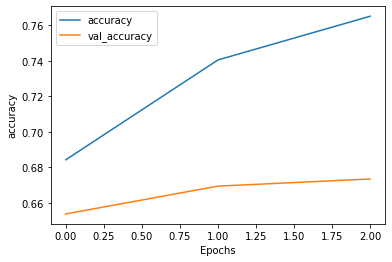

In [32]:
plot_graphs(history, 'accuracy')

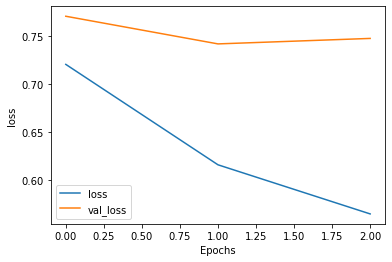

In [33]:
plot_graphs(history, 'loss')

## 모델 테스트

In [18]:
# Load Test dataset
TEST_XNLI_DF = os.path.join(DATA_IN_PATH, 'KorNLI', 'xnli.test.ko.tsv')

test_data_xnli = pd.read_csv(TEST_XNLI_DF, header=0, delimiter='\t', quoting=3)

In [19]:
# test_data_xnli = test_data_xnli[:50] # for test

test_data_sents = []

for test_sent_1, test_sent_2 in test_data_xnli[['sentence1', 'sentence2']].values:
    test_tokenized_sent_1 = vocab[tokenizer(clean_text(test_sent_1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(test_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)    

test_data_sents = np.array(test_data_sents, dtype=np.int64)

In [20]:
test_data_xnli["gold_label_int"] = test_data_xnli["gold_label"].apply(convert_int)
test_data_labels = np.array(test_data_xnli['gold_label_int'], dtype=int)

print("# sents: {}, # labels: {}".format(len(test_data_sents), len(test_data_labels)))

# sents: 5010, # labels: 5010


In [28]:
sim_model.load_weights("data_out/KOR/tf2_gpt_kornli/weights_kornli.h5")

ValueError: Cannot assign to variable tfgp_t2model/transformer/wpe/embeddings:0 due to variable shape (1024, 768) and value shape (50000, 768) are incompatible

In [ ]:
results = sim_model.evaluate(test_data_sents, test_data_labels)
print("test loss, test acc: ", results)

131/157 [========================>.....] - ETA: 2s - loss: 1.0947 - accuracy: 0.3593

In [23]:
def test_encode(test_sent_1,test_sent_2):

    test_data_sents = []

    test_tokenized_sent_1 = vocab[tokenizer(clean_text(test_sent_1))]
    test_tokenized_sent_2 = vocab[tokenizer(clean_text(test_sent_2))]

    tokens = [vocab[vocab.bos_token]] 
    tokens += pad_sequences([test_tokenized_sent_1], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.sep_token]]  
    tokens += pad_sequences([test_tokenized_sent_2], 
                            SENT_MAX_LEN, 
                            value=vocab[vocab.padding_token], 
                            padding='post').tolist()[0] 
    tokens += [vocab[vocab.eos_token]]

    test_data_sents.append(tokens)    

    test_data_sents = np.array(test_data_sents, dtype=np.int64)
    return test_data_sents

In [31]:
sentence1 = "남자가 웃고 있다."
sentence2 = "남자가 웃고 있다."
test_data_sents = test_encode(sentence1,sentence2)
results = sim_model.predict(test_data_sents)
print(np.argmax(results, axis=1))

[0]
